<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/tfsts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TF.Prob Structured Time Series**

**Import Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce
from scipy import stats
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import collections
import numpy as np
import tensorflow.compat.v2 as tf
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Import & Preprocess**

**Import data**

In [2]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


**Create tidy table** (just for fun)

In [0]:
tidy = pd.melt(data, id_vars=['Date'], value_vars=['Open', 'High', 'Low'],
              var_name='record_type', value_name='price')
tidy = tidy.set_index('Date')
tidy.head()

,record_type,price
Date,,
2010-02-01,Open,266.301849
2010-02-02,Open,266.481171
2010-02-03,Open,263.347900
2010-02-04,Open,267.497345
2010-02-05,Open,263.213409


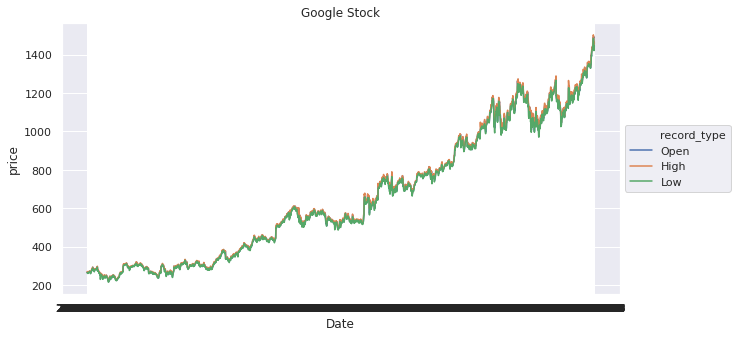

In [0]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.lineplot(data=tidy.reset_index(), x='Date', y='price', hue='record_type', ci=None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Google Stock')
plt.show()

**Preprocess Series**

In [3]:
series = data.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
series = series.rename(columns={"Date": "date", "Close": "price"})
series = series.set_index('date')
series.head()

,price
date,
2010-02-01,265.514771
2010-02-02,264.568329
2010-02-03,269.400208
2010-02-04,262.406433
2010-02-05,264.653015


**Adding first difference in case of unit root**

In [4]:
series['difference'] = ((series.price) - (series.price).shift(1))
series = series.dropna()
series.head()

,price,difference
date,,
2010-02-02,264.568329,-0.946442
2010-02-03,269.400208,4.831879
2010-02-04,262.406433,-6.993775
2010-02-05,264.653015,2.246582
2010-02-08,265.738953,1.085938


In [5]:
# How many times went the stock up of all movement?
"%s%% of rows have a delta > 0" % (len(series.loc[series.difference > 0]) / len((series.difference)) * 100)

'52.32604373757456% of rows have a delta > 0'

Seems like almost in the equal mount of time the stock price went up and down.

**Create Lagged Time Series**

In [7]:
lagged = concat([series.price.shift(1), series.price], axis=1)
lagged.columns = ['present', 'past']
lagged = lagged.dropna()
print(lagged.head(5))

               present        past
date                              
2010-02-03  264.568329  269.400208
2010-02-04  269.400208  262.406433
2010-02-05  262.406433  264.653015
2010-02-08  264.653015  265.738953
2010-02-09  265.738953  267.218414


*(Be aware: normally data preprocessing is normally a much larger step)*

# **Exploratory Data Analysis**

* Is there a seasonality?
* Is there a trend?
* Is there autocorrelation present?

**Time Series Summary**

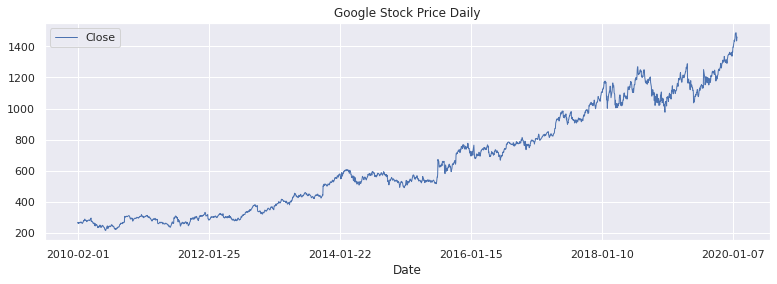

In [0]:
sns.set(rc={'figure.figsize':(13, 4)})
series.plot(linewidth=1.0,title='Google Stock Price Daily')

In [0]:
series.describe(percentiles=[0.05, 0.95])

,Close
count,2516.000000
mean,652.587282
std,331.360307
min,217.220810
5%,258.210923
50%,567.298034
95%,1216.795044
max,1486.650024


**Missing Values or Zeros**

In [0]:
# Check for missing values
series.isnull().sum()

Close    0
dtype: int64

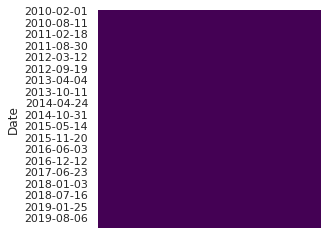

In [0]:
# Check for missing values
sns.set(rc={'figure.figsize':(4, 4)})
sns.heatmap(series.isnull(),xticklabels=False,cbar=False,cmap='viridis')

In [0]:
# Check for zeros
(series[series == 0]).count()

Close    0
dtype: int64

**Is the series normally distributed?**

Hypothesis: no.

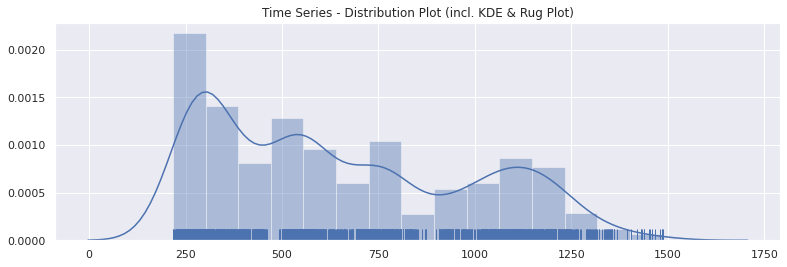

In [0]:

sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((series), hist=True, rug=True).set_title('Time Series - Distribution Plot (incl. KDE & Rug Plot)')
plt.show()

Text(0.5, 1.0, 'White Noise Process - Boxplot')

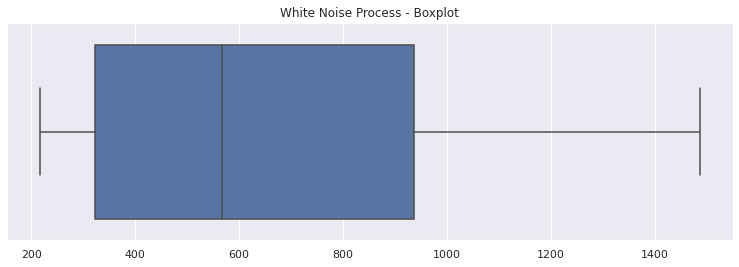

In [0]:
sns.boxplot(series).set_title('White Noise Process - Boxplot')

**Is there an autocorrelation?**

Hypothesis: Yes, with lag 1. Most financial time series are similar to markov processes with a dependency on one lag.

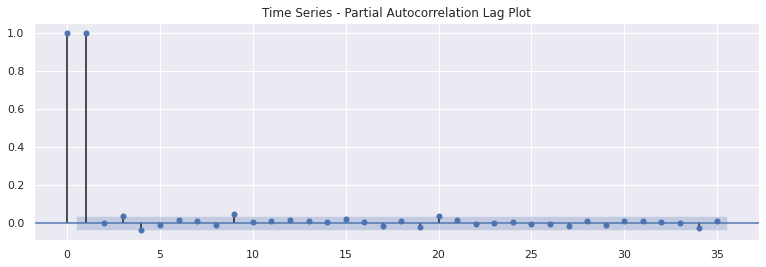

In [0]:
plot_pacf(series)
plt.title('Time Series - Partial Autocorrelation Lag Plot')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


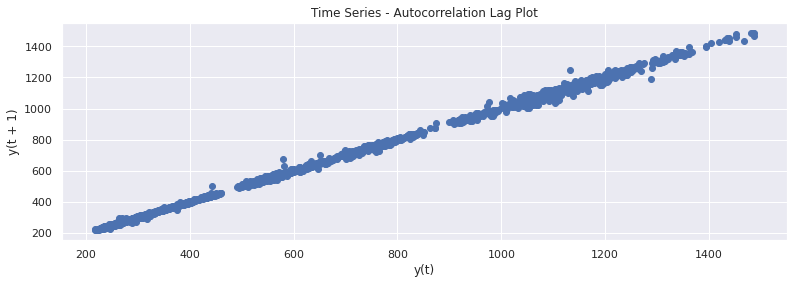

In [0]:
lag_plot(series)
plt.title('Time Series - Autocorrelation Lag Plot')
plt.show()

**Is the time series stationary?**

Hypohesis: It isn't. Most financial time series exhibit a unit root and need to be differenced once. Additionally they demonstrate a trend upward ('random walk with drift'). Also there might some seasonality.

In [0]:
# Augmented Dickery Fuller (H0: No stationarity)
df = series.price
statsmodels.tsa.stattools.adfuller(df, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(2.9224506092809115,
 0.9997106586717946,
 20,
 2495,
 {'1%': -2.5666366948727113,
  '10%': -1.6167139814432983,
  '5%': -1.9411081938603896},
 18866.08557404916)

Don't reject H0. Data is stationary and needs to be differenced.

In [0]:
# Run ADF test again on differenced time series
statsmodels.tsa.stattools.adfuller(series.difference, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-11.310406161579278,
 1.6526363287747393e-20,
 17,
 2497,
 {'1%': -2.566635976188647,
  '10%': -1.6167140660137316,
  '5%': -1.941108106771906},
 18865.78928513774)

Reject H0. Data is now stationary. Differencing once is called unit root, a typical characteristica of financial time series.

# **Base Model**

Let's run a simple base model to compare against.

In [9]:
# Train and Test Set
X = lagged.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

Test MSE: 238.908


There is still space for improvement, but let's run first a residual analysis.

# **Residual Analysis**

**What are residuals?**

For most (time series) models, the residuals are difference between observation and its corresponding estimated (fitted) value:

$e_{t} = y_{t} - \hat{y}_{t}$

**Why is it important to analyze residuals?**

Residuals are useful in checking whether a model has adequately captured the information in the data. In a good model the residuals are stationary. However one can classify the stationarity criteria in two distinct groups for residual analysis:

A good forecasting method will yield residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.

2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean m, then simply add m to all forecasts and the bias problem is solved. Fixing the correlation problem is harder, and we will not address it until Chapter 9.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

3. The residuals have constant variance.

4. The residuals are normally distributed.

These two properties make the calculation of prediction intervals easier (see Section 3.5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. Again, we will not address how to do this until later in the book.

[Source 1](https://otexts.com/fpp2/residuals.html)

[Source2 ](https://otexts.com/fpp2/prediction-intervals.html)

In [10]:
# Define residuals
residuals = (test_y - predictions)

# Convert from numpy.ndarray into pandas.DataFrame
residuals = pd.DataFrame(residuals,
                         columns=['res'])
residuals.head()

,res
0,8.619995
1,0.269959
2,-5.029969
3,-15.660034
4,9.360047


In [11]:
residuals.describe()

,res
count,855.000000
mean,0.803708
std,15.444773
min,-99.099976
25%,-5.709961
50%,0.920044
75%,8.654999
max,118.290039


Text(0.5, 0, 'Time step')

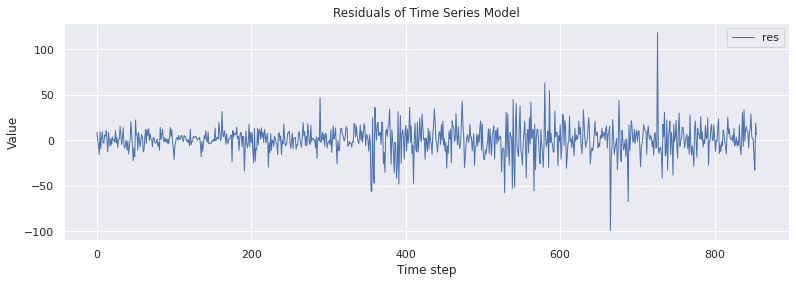

In [12]:
sns.set(rc={'figure.figsize':(13, 4)})
residuals.plot(linewidth=1.0,title='Residuals of Time Series Model')
plt.ylabel('Value')
plt.xlabel('Time step')

**Are the residuals normally distributed?**

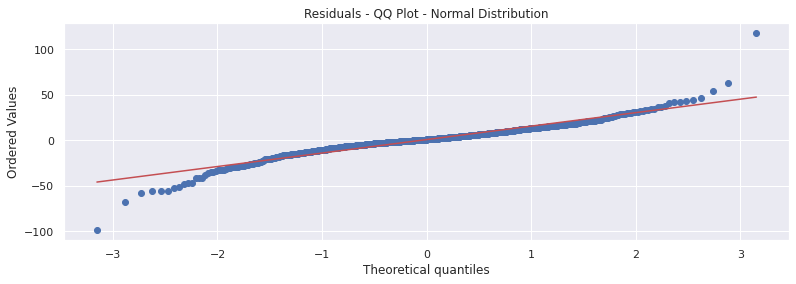

In [13]:
sns.set(rc={'figure.figsize':(13, 4)})
stats.probplot(residuals.res, dist="norm", plot=plt)
plt.title('Residuals - QQ Plot - Normal Distribution')
plt.show()

In [14]:
# Normal Test. H0: sample comes from a normal distribution
scipy.stats.normaltest(residuals.res)

NormaltestResult(statistic=140.19398076703737, pvalue=3.6079779807908435e-31)

Reject H0, residuals are not normally distributed

**Are the residuals autocorrelated?**


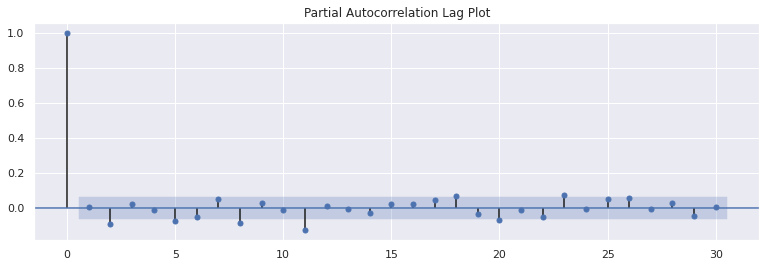

In [15]:
plot_pacf(residuals.res)
plt.title('Partial Autocorrelation Lag Plot')
plt.show()

In [16]:
# Durban Watson. H0: there is no serial correlation
statsmodels.stats.stattools.durbin_watson(residuals.res, axis=0)

1.9872349081330745

There is no autocorrelation present.

**Are the residuals stationary?**



In [17]:
# Augmented Dickery Fuller (H0: No stationarity)
statsmodels.tsa.stattools.adfuller(residuals.res, maxlag=None, regression='nc', autolag='AIC', store=False, regresults=False)

(-10.637832666141769,
 4.156197999474523e-19,
 10,
 844,
 {'1%': -2.568394143831001,
  '10%': -1.6165090758685048,
  '5%': -1.9413229184063758},
 6927.474836138723)

Residuals are stationary

In [18]:
# KPSS - Trend Stationary Test
# H0 = Deterministic Trend. H1 = Non-Stationary (Unit Root). Reject H0 if p-value of less than 5% 
statsmodels.tsa.stattools.kpss(residuals.res, regression='ct', lags='auto', store=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.04989278272239876,
 0.1,
 5,
 {'1%': 0.216, '10%': 0.119, '2.5%': 0.176, '5%': 0.146})

There is a deterministic trend present.

In [0]:
# KPSS - Level Stationary Test
# H0 = Stationary (Stochastic Trend). H1 = Non-Stationary (Unit Root). Reject H0 if p-value of less than 5%
statsmodels.tsa.stattools.kpss(residuals.res, regression='c', lags='auto', store=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.05802612414321132,
 0.1,
 4,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

# **Model Building with TF.Prob STS**

Clearly still some signal left in the residuals. Model is not good enough yet.

This analysis is inspired by this example: 
[Atmospheric CO2 and Electricity Demand](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) - ([Github](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb))

In [0]:
observed_time_series = series

In [0]:
holiday_indicators = np.zeros([31, 3])
holiday_indicators[23, 0] = 1  # Christmas Eve
holiday_indicators[24, 1] = 1  # Christmas Day
holiday_indicators[30, 2] = 1  # New Year's Eve

holidays = tfp.sts.LinearRegression(design_matrix=holiday_indicators,
                                    name='holidays')
day_of_week = tfp.sts.Seasonal(num_seasons=7,
                               observed_time_series=observed_time_series,
                               name='day_of_week')

In [0]:
model = tfp.sts.Sum(components=[holidays, seasonal],
                    observed_time_series=observed_time_series)